# Sparse Matrices

Focus on the example "Solving large sparse linear systems."

For the presentation, **add notes to the code**, explain its meaning and functionality.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import sparse
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_context('notebook', font_scale=1.5)

## Creating a sparse matrix

There are many applications in which we deal with matrices that are mostly zeros. For example, a matrix representing social networks is very sparse - there are 7 billion people, but most people are only connected to a few hundred or thousand others directly. Storing such a social network as a sparse rather than dense matrix  will offer orders of magnitude reductions in memory requirements and corresponding speed-ups in computation.

### Coordinate format

The simplest sparse  matrix format is built from the coordinates and values of the non-zero entries.

#### From dense matrix

In [4]:
A = np.random.poisson(0.2, (5,15)) * np.random.randint(0, 10, (5, 15))
A

array([[ 0,  0,  0,  0,  0,  8,  0,  4,  0,  0,  0,  6,  0,  0,  1],
       [ 0,  0,  0,  0,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  8,  7,  3,  2,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  4,  0,  0,  0, 16,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [5]:
np.nonzero(A)

(array([0, 0, 0, 0, 1, 2, 2, 2, 2, 3, 3, 4]),
 array([ 5,  7, 11, 14,  4,  3,  4,  5,  6,  2,  6,  5]))

In [6]:
rows, cols = np.nonzero(A)

In [7]:
rows

array([0, 0, 0, 0, 1, 2, 2, 2, 2, 3, 3, 4])

In [8]:
cols

array([ 5,  7, 11, 14,  4,  3,  4,  5,  6,  2,  6,  5])

In [9]:
vals = A[rows, cols]

In [10]:
vals

array([ 8,  4,  6,  1,  7,  8,  7,  3,  2,  4, 16,  4])

In [11]:
X1 = sparse.coo_matrix(A)
X1

<COOrdinate sparse matrix of dtype 'int64'
	with 12 stored elements and shape (5, 15)>

In [12]:
print(X1)

<COOrdinate sparse matrix of dtype 'int64'
	with 12 stored elements and shape (5, 15)>
  Coords	Values
  (0, 5)	8
  (0, 7)	4
  (0, 11)	6
  (0, 14)	1
  (1, 4)	7
  (2, 3)	8
  (2, 4)	7
  (2, 5)	3
  (2, 6)	2
  (3, 2)	4
  (3, 6)	16
  (4, 5)	4


#### From coordinates

Note that the (values, (rows, cols)) argument is a single tuple.

In [13]:
X2 = sparse.coo_matrix((vals, (rows, cols)))
X2

<COOrdinate sparse matrix of dtype 'int64'
	with 12 stored elements and shape (5, 15)>

In [14]:
print(X2)

<COOrdinate sparse matrix of dtype 'int64'
	with 12 stored elements and shape (5, 15)>
  Coords	Values
  (0, 5)	8
  (0, 7)	4
  (0, 11)	6
  (0, 14)	1
  (1, 4)	7
  (2, 3)	8
  (2, 4)	7
  (2, 5)	3
  (2, 6)	2
  (3, 2)	4
  (3, 6)	16
  (4, 5)	4


#### Convert back to dense matrix

In [15]:
X2.todense()

matrix([[ 0,  0,  0,  0,  0,  8,  0,  4,  0,  0,  0,  6,  0,  0,  1],
        [ 0,  0,  0,  0,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  8,  7,  3,  2,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  4,  0,  0,  0, 16,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

## Solving large sparse linear systems

SciPy provides efficient routines for solving large sparse systems as for dense matrices. We will illustrate by calculating the page rank  for airports using data from the [Bureau of Transportation Statisitcs](http://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236). The [PageRank](https://en.wikipedia.org/wiki/PageRank) algorithm is used to rank web pages for search results, but it can be used to rank any node in a directed graph (here we have airports instead of web pages). PageRank is fundamentally about finding the steady state in a Markov chain and can be solved as a linear system.

The update at each time step for the page rank $PR$ of a page $p_i$ is 

![i0](https://wikimedia.org/api/rest_v1/media/math/render/svg/8a8c0a807f62331cc1740dd6c0f28ac1809926c7)

The PageRank algorithm assumes that every node can be reached from every other node. To guard against case where a node has out-degree 0, we allow every node a small random chance of transitioning to any other node using a damping factor $R$. Then we solve  the linear system  to find the pagerank score $R$.

![i1](https://wikimedia.org/api/rest_v1/media/math/render/svg/6bb0f1469218a064274fd4691143e9ce64639dc2)

In matrix notation, this is

![i2](https://wikimedia.org/api/rest_v1/media/math/render/svg/96265e6c41318e793194287f36b5f929075bb876)

At steady state,

![i3](https://wikimedia.org/api/rest_v1/media/math/render/svg/65d2fed50688deaca4640b117c88a9e7a3c2ef0d)

and we can rearrange terms to solve for $R$

![i4](https://wikimedia.org/api/rest_v1/media/math/render/svg/985f19f0c6b69d3a8afb5acc38339ebe4915baa7)

In [16]:
data = pd.read_csv('airports.csv', usecols=[0,1])

In [17]:
data.shape

(445827, 2)

In [18]:
data.head()

,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID
0,10135,10397
1,10135,10397
2,10135,10397
3,10135,10397
4,10135,10397


In [19]:
lookup = pd.read_csv('names.csv', index_col=0)

In [20]:
lookup.shape

(6404, 1)

In [21]:
lookup.head()

,Description
Code,
10001,"Afognak Lake, AK: Afognak Lake Airport"
10003,"Granite Mountain, AK: Bear Creek Mining Strip"
10004,"Lik, AK: Lik Mining Camp"
10005,"Little Squaw, AK: Little Squaw Airport"
10006,"Kizhuyak, AK: Kizhuyak Bay"


In [22]:
import networkx as nx

#### Construct the sparse adjacency matrix

In [23]:
g = nx.from_pandas_edgelist(data, source='ORIGIN_AIRPORT_ID', target='DEST_AIRPORT_ID')

In [36]:
airports = np.array(g.nodes())
adj_matrix = nx.to_scipy_sparse_array(g)

len(airports)
adj_matrix.shape

(294, 294)

In [38]:
print(adj_matrix)

<Compressed Sparse Row sparse array of dtype 'int64'
	with 4026 stored elements and shape (294, 294)>
  Coords	Values
  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (1, 0)	1
  (1, 2)	1
  (1, 3)	1
  (1, 4)	1
  (1, 5)	1
  (1, 6)	1
  (1, 7)	1
  (1, 8)	1
  (1, 9)	1
  (1, 10)	1
  (1, 11)	1
  (1, 12)	1
  (1, 13)	1
  (1, 14)	1
  (1, 15)	1
  (1, 16)	1
  (1, 17)	1
  (1, 18)	1
  (1, 19)	1
  (1, 20)	1
  (1, 21)	1
  (1, 22)	1
  :	:
  (279, 276)	1
  (279, 278)	1
  (280, 12)	1
  (280, 13)	1
  (280, 14)	1
  (281, 12)	1
  (281, 13)	1
  (281, 14)	1
  (282, 8)	1
  (283, 6)	1
  (283, 9)	1
  (283, 14)	1
  (284, 5)	1
  (284, 238)	1
  (285, 3)	1
  (286, 3)	1
  (287, 13)	1
  (288, 12)	1
  (289, 9)	1
  (290, 13)	1
  (291, 13)	1
  (292, 9)	1
  (292, 11)	1
  (292, 13)	1
  (293, 175)	1


#### Construct the transition matrix

In [25]:
out_degrees = np.ravel(adj_matrix.sum(axis=1))
diag_matrix = sparse.diags(1 / out_degrees).tocsr()
M = (diag_matrix @ adj_matrix).T

In [26]:
n = len(airports) 
d = 0.85 
I = sparse.eye(n, format='csc')
A = I - d * M
b = (1-d) / n * np.ones(n) # so the sum of all page ranks is 1

In [27]:
A.todense()

matrix([[ 1.        , -0.00537975, -0.0085    , ...,  0.        ,
          0.        ,  0.        ],
        [-0.28333333,  1.        , -0.0085    , ...,  0.        ,
          0.        ,  0.        ],
        [-0.28333333, -0.00537975,  1.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  1.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          1.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  1.        ]])

In [28]:
from scipy.sparse.linalg import spsolve

In [29]:
r =  spsolve(A, b)
r.sum()

0.9999999999999999

In [30]:
idx = np.argsort(r)

In [31]:
top10 = idx[-10:][::-1]
bot10 = idx[:10]

In [32]:
df = lookup.loc[airports[top10]]
df['degree'] = out_degrees[top10]
df['pagerank']= r[top10]
df

,Description,degree,pagerank
Code,,,
10397,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern...",158,0.043286
13930,"Chicago, IL: Chicago O'Hare International",139,0.033956
11292,"Denver, CO: Denver International",129,0.031434
11298,"Dallas/Fort Worth, TX: Dallas/Fort Worth Inter...",108,0.027596
13487,"Minneapolis, MN: Minneapolis-St Paul Internati...",108,0.027511
12266,"Houston, TX: George Bush Intercontinental/Houston",110,0.025967
11433,"Detroit, MI: Detroit Metro Wayne County",100,0.024738
14869,"Salt Lake City, UT: Salt Lake City International",78,0.019298
14771,"San Francisco, CA: San Francisco International",76,0.017820


In [33]:
df = lookup.loc[airports[bot10]]
df['degree'] = out_degrees[bot10]
df['pagerank']= r[bot10]
df

,Description,degree,pagerank
Code,,,
14025,"Plattsburgh, NY: Plattsburgh International",1,0.000693
12265,"Niagara Falls, NY: Niagara Falls International",1,0.000693
11695,"Flagstaff, AZ: Flagstaff Pulliam",1,0.000693
16218,"Yuma, AZ: Yuma MCAS/Yuma International",1,0.000693
14905,"Santa Maria, CA: Santa Maria Public/Capt. G. A...",1,0.000710
14487,"Redding, CA: Redding Municipal",1,0.000710
13964,"North Bend/Coos Bay, OR: Southwest Oregon Regi...",1,0.000710
10157,"Arcata/Eureka, CA: Arcata",1,0.000710
12177,"Hobbs, NM: Lea County Regional",1,0.000711


#### Visualize the airport connections graph and label the top and bottom 5 airports by pagerank

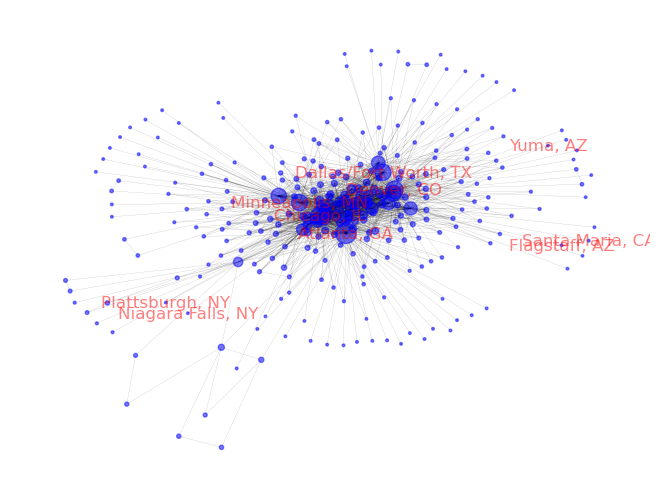

In [34]:
labels = {airports[i]: lookup.loc[airports[i]].str.split(':').str[0].values[0] 
          for i in np.r_[top10[:5], bot10[:5]]}
nx.draw(g, pos=nx.spring_layout(g), labels=labels, 
        node_color='blue', font_color='red', alpha=0.5,
        node_size=np.clip(5000*r, 1, 5000*r), width=0.1)